In [158]:
import warnings
warnings.filterwarnings('ignore')
from CliqueMaster import CliqueMaster
from Clique import Clique
import os
import sys

# Initiate
Cm = CliqueMaster()
times = dict()
nodes = dict()
nb_lines = 0
resurrect = False

omega = None
old_b = None
old_e = 0

file_name = "./test_link.txt"
file = open(file_name, 'r')

#sys.stdout = open(os.devnull, 'w')

In [159]:
test_ls = []
for line in file:
    contents = line.split()
    b = float(contents[0])
    e = float(contents[1])
    u = contents[2].strip()
    v = contents[3].strip()
    test_ls.append([b,e,u,v])

In [160]:
def get_cliques(ls):
    Cm = CliqueMaster()
    times = dict()
    nodes = dict()
    nb_lines = 0
    resurrect = False
    
    omega = None
    old_b = None
    old_e = 0
    
    for link in ls:
        b = link[0]
        e = link[1]
        u = link[2]
        v = link[3]
        
        if omega == None or omega < e:
            omega = e


        link = frozenset([u, v])
        time = (b, b)

        # This a new instance
        Cm.addClique(Clique((link, time), set([])))

        # Populate data structures
        if link not in times:
            times[link] = []
        times[link].append((b,e))

        if u not in nodes:
            nodes[u] = set()

        if v not in nodes:
            nodes[v] = set()

        nodes[u].add(v)
        nodes[v].add(u)

        assert(b <= e)
        assert( (old_b == None) or (b >= old_b) )
        if b == old_b:
            assert(e >= old_e)

        (old_b,old_e) = (b,e)
        nb_lines = nb_lines + 1

    Cm._times = times
    Cm._nodes = nodes


    # Start execution
    R = Cm.getMaximalCliques(omega)
    return R

In [161]:
r = get_cliques(test_ls)

In [162]:
r

{1,3,2 0.0,0.0}

## Socio's High School Dataset

In [198]:
import pandas as pd
data = pd.read_csv('./High-School_data_2013.csv', header = None, delimiter='\t')
stream = data[0]

In [199]:
def time_b(link):
    return link[0]

def time_e(link):
    return link[1]

def time_la(link):
    return link[0] * 1000000 + link[1]

def order(link):
    time = link[0]
    s = link[2] + link[3]
    s = int(s)
    return s*1000000 + time

In [200]:
min_time = 1385982000
unprocessed_links_stream = []
for line in stream:
    time, s1, s2 = line.split(' ')[0:3]
    time = int(time) - min_time
    if int(s1) > int(s2):
        temp = s1
        s1 = s2
        s2 = temp
    link = [time - 20, time, s1, s2]
    unprocessed_links_stream.append(link)
sorted_links_stream = sorted(unprocessed_links_stream, key=order)

In [201]:
import copy
merged_links_stream = []
l = len(sorted_links_stream)
flag = [False] * l
for i in range(l):
    if flag[i] == True:
        continue
    flag[i] == True
    l1 = copy.deepcopy(sorted_links_stream[i])
    for j in range(i+1, l):
        if flag[j] == True:
            continue
        l2 = copy.deepcopy(sorted_links_stream[j])
        if l2[2] != l1[2] or l2[3] != l1[3] or l2[0] > l1[1] + 20:
            merged_links_stream.append(l1)
            break
        if l1[1] + 20 >= l2[0]:
            l1[1] = l2[1]
            flag[j] = True

In [202]:
la = sorted(merged_links_stream, key = time_la)

In [221]:
import copy
na = copy.deepcopy(la)
for i in range(len(la)):
    l1 = la[i]
    v1 = set([l1[2], l1[3]])
    for j in range(i+1, len(la)):
        l2 = la[j]
        v2 = set([l2[2], l2[3]])
        if any(v in v1 for v in v2) and not all(v in v1 for v in v2):
            common_vertex = v1.intersection(v2)
            v1 = v1.difference(common_vertex)
            v2 = v2.difference(common_vertex)
            a = v1.pop()
            b = v2.pop()
            if a > b:
                tmp = b
                b = a
                a = tmp
            if min(l1[1], l2[1]) - max(l1[0], l2[0]) > 0:
                na.append([max(l1[0], l2[0]), min(l1[1], l2[1]), a, b])

In [222]:
na = sorted(na, key=order)
merged_links_stream = []
l = len(na)
flag = [False] * l
for i in range(l):
    if flag[i] == True:
        continue
    flag[i] == True
    l1 = copy.deepcopy(na[i])
    for j in range(i+1, l):
        if flag[j] == True:
            continue
        l2 = copy.deepcopy(na[j])
        if l2[2] != l1[2] or l2[3] != l1[3] or l2[0] > l1[1] + 20:
            merged_links_stream.append(l1)
            break
        if l1[1] >= l2[0]:
            l1[1] = l2[1]
            flag[j] = True

In [224]:
na = sorted(merged_links_stream, key=time_la)

In [225]:
cliques = get_cliques(na)

In [226]:
import pickle
pickle.dump(cliques, open("2_distance_high_school_cliques.p", "wb"))

In [10]:
import pickle
pickle.dump( cliques, open("high_school_cliques.p", "wb"))

## Creating graph

In [11]:
import pickle
cliques = pickle.load( open("high_school_cliques.p", "rb" ) )

In [12]:
node_clique_dict = {}
i = 0
for clique in cliques:
    node_clique_dict.update({i : clique})
    i += 1

In [13]:
pickle.dump(node_clique_dict, open("node_clique_dict.p", "wb"))

In [14]:
import networkx as nx
G = nx.DiGraph()
for key in node_clique_dict:
    G.add_node(key)

In [15]:
import time
start = time.time()
counter = 0
for n1 in G.node:
    if counter % 2000 == 0:
        start = time.time()
    c1 = node_clique_dict[n1]
    for n2 in G.node:
        if n1 == n2:
            continue
        c2 = node_clique_dict[n2]
        if c1._tb >= c2._tb and c1._te <= c2._te and all(x in c1._X for x in c2._X):
            G.add_edge(n1, n2)
    counter += 1
    if counter % 2000 == 0:
        end = time.time()
        print('step ' + str(counter) + ', time = ' + str(end - start))

step 2000, time = 35.774338245391846
step 4000, time = 35.69455122947693
step 6000, time = 35.94688391685486
step 8000, time = 36.24810767173767
step 10000, time = 36.30691385269165
step 12000, time = 36.27600336074829
step 14000, time = 36.78977608680725
step 16000, time = 36.44342827796936
step 18000, time = 36.10545539855957
step 20000, time = 35.90003728866577
step 22000, time = 36.30089998245239
step 24000, time = 36.31389665603638
step 26000, time = 36.06256937980652
step 28000, time = 35.70256423950195
step 30000, time = 35.69754672050476
step 32000, time = 35.91097402572632
step 34000, time = 36.255054235458374
step 36000, time = 36.99804329872131
step 38000, time = 36.460537910461426
step 40000, time = 36.261040925979614
step 42000, time = 36.74873495101929
step 44000, time = 36.552292346954346
step 46000, time = 36.72679424285889
step 48000, time = 36.89833474159241
step 50000, time = 36.3876678943634
step 52000, time = 36.690889835357666
step 54000, time = 36.679954290390015

In [36]:
pickle.dump(G, open("high_school_cliques_graph.p", "wb"))

## K-distance Cliques

In [1]:
import pickle
graph = pickle.load(open("high_school_cliques_graph.p", "rb" ))
node_clique_dict = pickle.load(open("node_clique_dict.p", "rb"))

In [2]:
def maximal_clique(graph):
    out_vertices = set()
    forbid = set()
    for edge in graph.edges:
        forbid.add(edge[1])
    
    for edge in graph.edges:
        if edge[0] not in forbid:
            out_vertices.add(edge[0])
            
    result = []
    for node in out_vertices:
        maximal_clique = []
        vertices_set = set()
        origin_clique = node_clique_dict[node]
        v = [node for node in origin_clique._X]
        for i in range(len(v)):
            for j in range(i, len(v)):
                if v[i] < v[j]:
                    vertices_set.add((v[i], v[j]))
                elif v[i] > v[j]:
                    vertices_set.add((v[j], v[i]))
                    
        for pair in vertices_set:
            maximal_clique.append([pair, origin_clique._tb, origin_clique._te])
                
        for n in graph.neighbors(node):
            c = node_clique_dict[n]
            v = [node for node in c._X]
            for v1 in v:
                for v2 in v:
                    if (v1, v2) in vertices_set:
                        for link in maximal_clique:
                            if link[0] == (v1, v2):
                                maximal_clique.remove(link)
                                maximal_clique.append([(v1, v2), c._tb, c._te])
        result.append(maximal_clique)
    return result

In [230]:
two_distance_clique = pickle.load(open("./2_distance_high_school_cliques.p", 'rb'))

In [231]:
needed = []
for c in two_distance_clique:
    buffer = []
    for e in c._X:
        buffer.append(e)
    needed.append(buffer)

In [163]:
def expand(graph, k_clique):
    result = []
    d = {}
    for node in k_clique:
        edges_set = set()
        origin_clique = node_clique_dict[node]
        v = [node for node in origin_clique._X]
        for i in range(len(v)):
            for j in range(i, len(v)):
                if v[i] < v[j]:
                    edges_set.add((v[i], v[j]))
                elif v[i] > v[j]:
                    edges_set.add((v[j], v[i]))
                    
        for pair in edges_set:
            link = [pair, origin_clique._tb, origin_clique._te]
            d.update({pair : [link]})
                
        for n in graph.neighbors(node):
            c = node_clique_dict[n]
            v = [node for node in c._X]
            edges_set = set()
            for i in range(len(v)):
                for j in range(i, len(v)):
                    if v[i] < v[j]:
                        edges_set.add((v[i], v[j]))
                    elif v[i] > v[j]:
                        edges_set.add((v[j], v[i]))
                        
            for pair in edges_set:
                link =[pair, c._tb, c._te]
                for l in d[pair]:
                    if l[1] >= link[1] and l[2] <= link[2]:
                        d[pari].append(link)
                        d[pair].remove(l)
                        break
                    if l[1] <= link[1] and l[2] >= link[2]:
                        break
                    if l[1] > link[2] or link[1] > l[2]:
                        d[pair].append(link)
                                

    for key in d:
        for link in d[key]:
            result.append(link)
                                
    return result                        

In [193]:
import networkx as nx
def k_distance_graph(graph, k = 2):
    out_vertices = set()
    forbid = set()
    for edge in graph.edges:
        forbid.add(edge[1])
    
    for edge in graph.edges:
        if edge[0] not in forbid:
            out_vertices.add(edge[0])
            
    result = []
    G = nx.Graph()
    G.add_nodes_from(out_vertices)
    for n1 in G.node:
        for n2 in G.node:
            if n1 == n2:
                continue
            s1 = set(graph.neighbors(n1))
            s2 = set(graph.neighbors(n2))
            if any(x in s1 for x in s2):
                G.add_edge(n1, n2)
    
    return G

In [194]:
G = k_distance_graph(graph)

In [195]:
L = []
for edge in G.edges:
    L.append([0, 0, edge[0], edge[1]])

In [197]:
len(L)

8619

## Density

In [154]:
def begin_time(link):
    return link[0]

def overlap(a, b):
    if max(0, min(a[1], b[1]) - max(a[0], b[0])) > 0:
        return True
    else:
        return False
    
def activation_time(n, stream):
    result = []
    stream = sorted(stream, key = begin_time)
    for link in stream:
        if n in link[0]:
            i = [link[1], link[2]]
            ol = False
            for interval in result:
                if overlap(interval, i):
                    result.remove(interval)
                    result.append([min(i[0], interval[0]), max(i[1], interval[1])])
                    ol = True
                    break
            if not ol:
                result.append(i)
    return result

def intersect_activation_time(n1, n2, stream):
    t1 = activation_time(n1, stream)
    t2 = activation_time(n2, stream)
    result = 0
    for i1 in t1:
        for i2 in t2:
            result += max(0, min(i1[1], i2[1]) - max(i1[0], i2[0]))
    return result

In [155]:
def density(stream):
    nominator = 0
    for link in stream:
        nominator += link[2] - link[1]
        
    denominator = 0
    for link in stream:
        denominator += intersect_activation_time(link[0][0], link[0][1], stream)
        
    return nominator / denominator

In [156]:
mc = maximal_clique(graph)

In [232]:
two_mc = []
for e in needed:
    two_mc.append(expand(graph, e))

KeyError: '1819'

In [148]:
two_mc

[[[('1894', '866'), 165740, 165760],
  [('1870', '1894'), 165680, 165760],
  [('277', '866'), 165740, 165760],
  [('1870', '866'), 165740, 165760],
  [('1870', '277'), 165720, 165760],
  [('1894', '277'), 165500, 165760]],
 [[('240', '626'), 93940, 94040],
  [('122', '240'), 93680, 94220],
  [('122', '626'), 93960, 94040],
  [('101', '122'), 93680, 94020],
  [('101', '240'), 93440, 93920],
  [('240', '70'), 94160, 94180],
  [('101', '70'), 94120, 94180],
  [('122', '70'), 94060, 94320],
  [('122', '364'), 93680, 93860],
  [('101', '364'), 93640, 93860],
  [('240', '364'), 93320, 93860]],
 [[('1204', '1342'), 84520, 84720],
  [('1342', '1359'), 84580, 84980],
  [('1204', '1359'), 84520, 84660]],
 [[('1201', '1594'), 94900, 95120],
  [('1201', '1828'), 94960, 94980],
  [('1594', '1828'), 94920, 95000]],
 [[('196', '871'), 267660, 267680],
  [('39', '871'), 267620, 267700],
  [('196', '39'), 267640, 267680],
  [('265', '871'), 267580, 267640],
  [('265', '39'), 267640, 267680],
  [('196',

In [149]:
X = [density(stream) for stream in mc]

In [150]:
Y = [density(stream) for stream in two_mc]

## Plotting

In [103]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

C:\Users\tungu\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


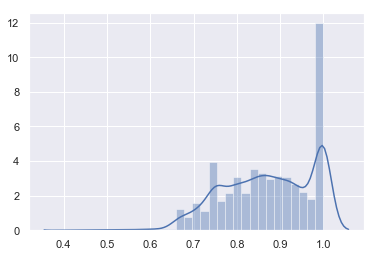

In [104]:
sns.set(color_codes=True)
sns.distplot(X)

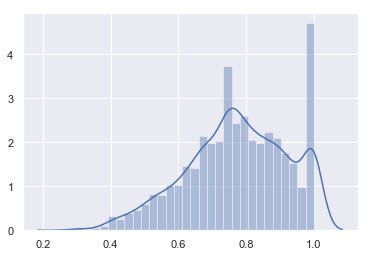

In [151]:
sns.distplot(Y)

In [33]:
node_clique_dict[43362]

1594,1828 95100,95360

In [209]:
a = set()

In [210]:
a.add(0)


In [211]:
a

{0}

In [212]:
x = a.pop()

In [213]:
x

0

In [152]:
len([[('407', '991'), 266360, 266380],
  [('407', '65'), 266260, 266380],
  [('407', '531'), 266300, 266320],
  [('531', '991'), 266360, 266380],
  [('531', '65'), 266300, 266380],
  [('65', '991'), 266360, 266460],
  [('945', '991'), 266360, 266400],
  [('65', '945'), 266340, 266600],
  [('407', '945'), 266220, 266380],
  [('177', '407'), 266260, 266360],
  [('177', '945'), 266400, 266500],
  [('177', '65'), 266320, 266480],
  [('177', '531'), 266380, 266400],
  [('177', '991'), 266400, 266440]],)

14

In [83]:
hash('101' + '756' + str(94160) + str (94160))

1216440879223036995

In [217]:
a = set([1,2])

In [218]:
a

{1, 2}